In [1]:
import numpy as np
import sys
import os
import glob
import csv
import re
import time
import copy

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits import mplot3d

%matplotlib inline
plt.style.use("seaborn") # plt.style.available

In [3]:
# Globals
datadir = "C:/Users/mholub/data/sicm/2018/11_Nov/26"

## Cyclic Voltametry

In [41]:
# Locals
exp_name = "cv2"

In [42]:
files, date = get_files(datadir, exp_name)
result = load_result(files)

dict_keys(['Current1(A)', 'dt(s)', 'LineNumber', 'V1(V)', 'Z(um)'])
Number of datapoints = (7802,)


Text(0, 0.5, 'LineNumber')

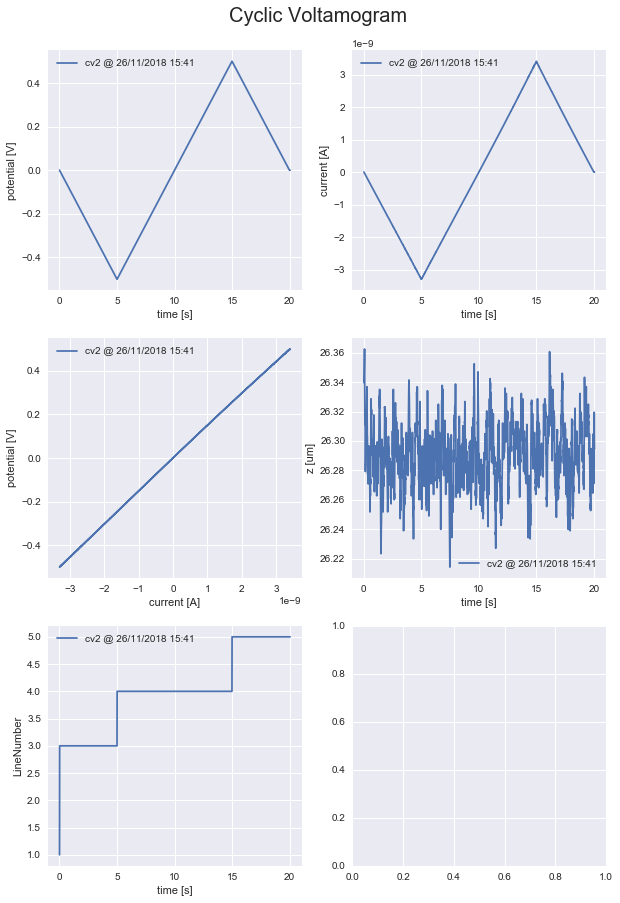

In [128]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
axs = axs.flatten()
fig.suptitle("Cyclic Voltamogram", size = 20, y = 0.92)

axs[0].plot(np.cumsum(result["dt(s)"]), result["V1(V)"])
axs[0].legend(["{} @ {}".format(exp_name, date)])
axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("potential [V]")

axs[1].plot(np.cumsum(result["dt(s)"]), result["Current1(A)"])
axs[1].legend(["{} @ {}".format(exp_name, date)])
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("current [A]")

axs[2].plot(result["Current1(A)"], result["V1(V)"])
axs[2].legend(["{} @ {}".format(exp_name, date)])
axs[2].set_xlabel("current [A]")
axs[2].set_ylabel("potential [V]")

axs[3].plot(np.cumsum(result["dt(s)"]), result["Z(um)"])
axs[3].legend(["{} @ {}".format(exp_name, date)])
axs[3].set_xlabel("time [s]")
axs[3].set_ylabel("z [um]")

axs[4].plot(np.cumsum(result["dt(s)"]), result["LineNumber"])
axs[4].legend(["{} @ {}".format(exp_name, date)])
axs[4].set_xlabel("time [s]")
axs[4].set_ylabel("LineNumber")


# not used
# xticks = ax.get_xticks(); xmin = np.min(xticks); xmax = np.max(xticks);
# yticks = ax.get_yticks(); ymin = np.min(yticks); ymax = np.max(yticks);
# ax.set_xticks(np.arange(xmin, xmax,  (xmax-xmin) / 10))
# ax.set_yticks(np.arange(ymin, ymax,  (ymax-ymin) / 10))

## Hopping Scan

In [212]:
%load_ext autoreload
%autoreload 2

from sicm import io, plots
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
# Globals
datadir = "C:/Users/mholub/data/sicm/2018/11_Nov/26"
# Locals
exp_name = "scan3"

In [214]:
files, date = io.get_files(datadir, exp_name)
result_ = io.load_result(files, exp_name)

uniqs, cnts = np.unique(result_["LineNumber"], return_counts=True)
linenos = np.arange(5, max(uniqs), 3)
result = io.downsample_to_linenumber(result_, linenos, which = "last")

dict_keys(['Current1(A)', 'dt(s)', 'LineNumber', 'V1(V)', 'X(um)', 'Y(um)', 'Z(um)'])
Number of datapoints = (1094048,)
Number of datapoints = 2916


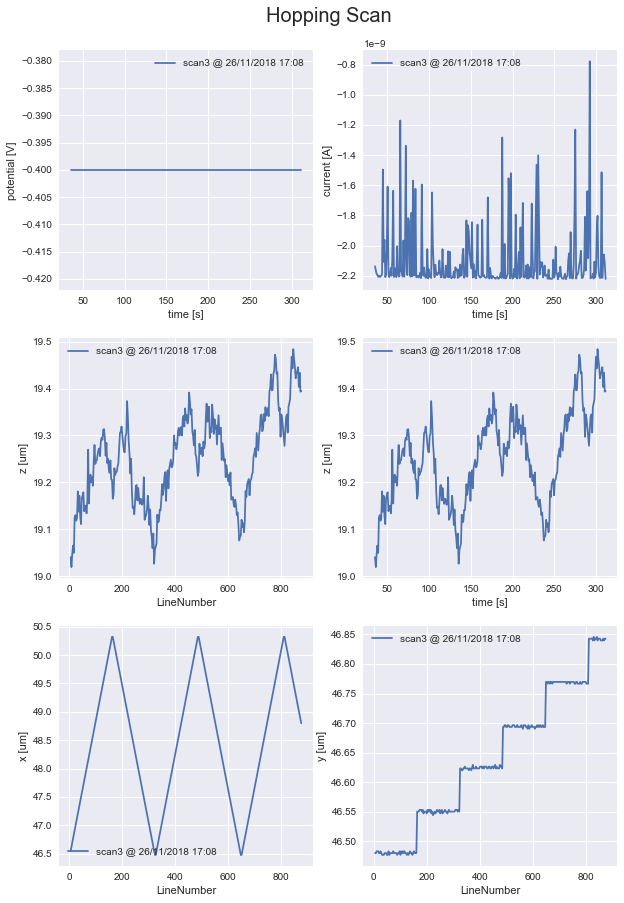

In [216]:
sel = np.arange(0, len(result["LineNumber"])//10)
plots.plot_hopping_scan(result, sel, exp_name, date)

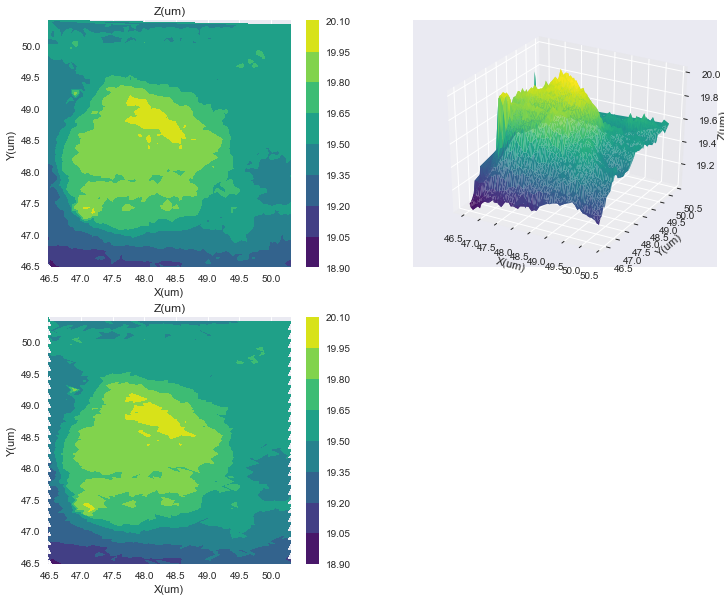

In [217]:
plots.plot_surface(result)

### Quartz Tuning Fork

In [3]:
from sicm import io, plots

In [4]:
# Globals
datadir = "C:/Users/mholub/data/sicm/2018/11_Nov/27"

In [5]:
# Locals
exp_name = "scan4"

In [6]:
files, date = io.get_files(datadir, exp_name)
result_ = io.load_result(files, exp_name)

uniqs, cnts = np.unique(result_["LineNumber"], return_counts=True)
linenos = np.arange(5, max(uniqs), 3)
result = io.downsample_to_linenumber(result_, linenos, which = "last")

dict_keys(['dt(s)', 'LineNumber', 'LockinPhase', 'LockinAmplitude', 'X(um)', 'Y(um)', 'Z(um)'])
Number of datapoints = (246802,)
Number of datapoints = 1600


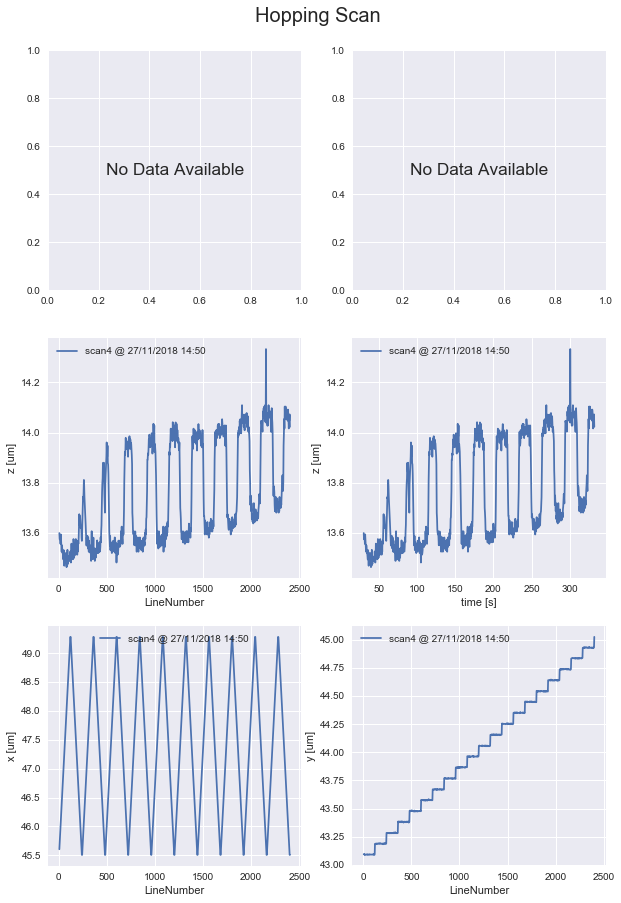

In [7]:
sel = np.arange(0, len(result["LineNumber"])//2)
plots.plot_hopping_scan(result, sel, exp_name, date)

In [8]:
plots.plot_surface(result, transpose=False)

ModuleNotFoundError: No module named 'ipympl'

# Lock-in

TODO:
    - put code to sicm package
    - add comments, polish
    - brainstorm if more needed to be plotted

In [51]:
import csv
import os
import time
import numpy as np
from matplotlib import pyplot as plt

def load_data_lockin(folder = ".", fname = "", chunk = 0):
    """Load data exported by ZHInst LabOne
    """
    fname = os.path.abspath(os.path.join(folder, fname))
    assert os.path.isfile(fname), "File does not exist"
    assert isinstance(chunk, (int, )), "Chunk is not an integer"
    print("Exctracting chunk {} from file {}.".format(chunk, fname))
    
    with open(fname, "r") as rf:
        ssvf = csv.reader(rf, delimiter = ";")
        headline = next(ssvf) # skip header line
        first_line = None
        result = {}
        for i, row in enumerate(ssvf):
            if int(row[0]) != chunk: continue
            if not first_line: 
                first_line = i
                timestamp = int(row[1])
                size = int(row[2])
            result[row[3]] =  np.asarray(list(map(float, filter(None, row[4:]))))

                
    if len(set(map(len, result.values()))) not in (0, 1):
        raise ValueErrorr('not all arrays have same length!')
    
    # Their timestamp is not what we expect, take it from file modification time
    timestamp = os.path.getmtime(fname) 
    t = time.localtime(timestamp)
    date = "{:02d}/{:02d}/{:04d} {:02d}:{:02d}".format(t.tm_mday, t.tm_mon, t.tm_year,
                                                       t.tm_hour, t.tm_min)
    
    print("Experiment time: {}, # of points: {}".format(date, size))
    
    return(result, date)

def plot_lockin(data = {}, keys = [("frequency", "r")], date = None):
    """Plot data collected by lockin amplifier
    
    References:
      https://www.zhinst.com/sites/default/files/LabOneProgrammingManual_42388.pdf
    """
    if not isinstance(keys, (list, )): keys = [keys]
    nplots = len(keys)
    nrows = nplots // 2
    if nplots % 2 == 1: nrows += 1
    ncols = 2 if nplots > 1 else 1
    
    # units mapping
    labels = {"frequency": "f [Hz]",
             "r": "amplitude [V]",
             "phase": r'$\theta$ [rad]',
             "phasepwr": r'$\theta^2$ [$rad^2$]',
             "x": "x-value [V]", "y": "y-value [V]"}
    
    fig, axs = plt.subplots(nrows, ncols, squeeze = False, 
                            figsize = (ncols*6.4, nrows*4.8))
    axs = axs.flatten()
    #     fig.tight_layout()
    text = "Oscilator"
    if date:
        text = "{} @ {}".format(text, date)
    fig.suptitle(text, size  = 16, y = 0.92)
    
    for i, k in enumerate(keys):
        try:
            axs[i].plot(data[k[0]], data[k[1]])
            axs[i].set_xlabel(labels[k[0]])
            axs[i].set_ylabel(labels[k[1]])
            axs[i].set_title(" ".join(labels[k[1]].split(" ")[:-1]))
        except KeyError as e:
            pass # plot_mock(axs[i])

In [31]:
%load_ext autoreload
%autoreload 2

from sicm import io, plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Globals
datadir = "C:/Users/mholub/data/sicm/2018/11_Nov/30/session_20181130_145223_03/sweep1_001"
file = "dev662_demods_0_sample_00000.csv"
data, date = load_data_lockin(datadir, file, chunk = 3)

Exctracting chunk 3 from file C:\Users\mholub\data\sicm\2018\11_Nov\30\session_20181130_145223_03\sweep1_001\dev662_demods_0_sample_00000.csv.
Experiment time: 30/11/2018 15:10, # of points: 1000


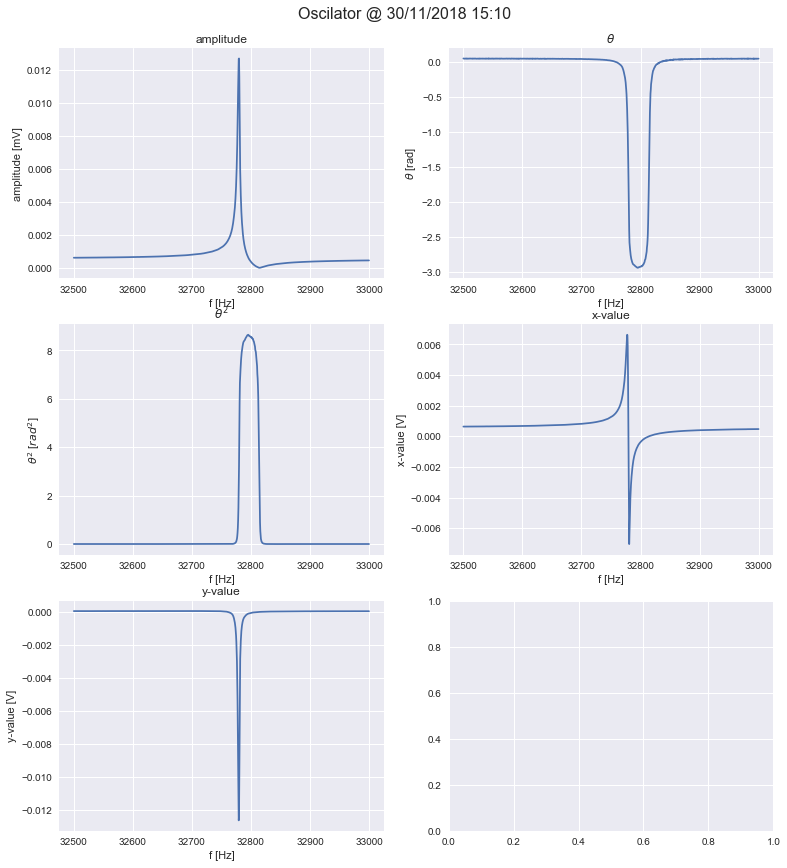

In [52]:
plot_lockin(data, 
            keys = [("frequency", "r"), ("frequency", "phase"), 
                   ("frequency", "phasepwr"), ("frequency", "x"),
                   ("frequency", "y")], 
            date = date)